<a href="https://colab.research.google.com/github/nitinredddy/IMDB-Dataset-analysis/blob/main/IMDB_Dataset_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load dataset with error handling
try:
    data = pd.read_csv("IMDB Dataset.csv", encoding="utf-8", on_bad_lines="skip")  # Skips malformed rows
except Exception as e:
    print("Error reading CSV file:", e)
    exit()

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase for consistency
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and special characters
    return text

# Apply text preprocessing
data['review'] = data['review'].astype(str).apply(preprocess_text)  # Ensure reviews are strings
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})  # Convert labels to binary

In [2]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['review'], data['sentiment'], test_size=0.2, random_state=42)

In [3]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
test_tfidf = tfidf_vectorizer.transform(test_texts)

In [4]:
classifier = LogisticRegression()
classifier.fit(train_tfidf, train_labels)
predictions = classifier.predict(test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(test_labels, predictions))
print(classification_report(test_labels, predictions))

Logistic Regression Accuracy: 0.8932
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



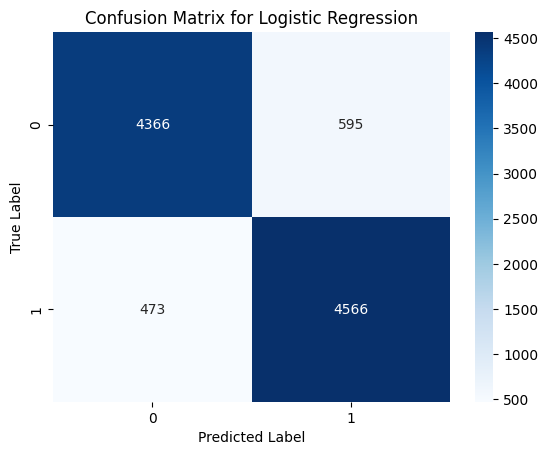

In [5]:
conf_matrix = confusion_matrix(test_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [6]:
max_vocab_size = 5000
max_sequence_length = 200

text_tokenizer = Tokenizer(num_words=max_vocab_size)
text_tokenizer.fit_on_texts(train_texts)
train_sequences = pad_sequences(text_tokenizer.texts_to_sequences(train_texts), maxlen=max_sequence_length)
test_sequences = pad_sequences(text_tokenizer.texts_to_sequences(test_texts), maxlen=max_sequence_length)

In [7]:
lstm_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(train_sequences, train_labels, epochs=5, batch_size=64, validation_data=(test_sequences, test_labels))

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 255s 397ms/step - accuracy: 0.7607 - loss: 0.4752 - val_accuracy: 0.8784 - val_loss: 0.3003
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 259s 393ms/step - accuracy: 0.8876 - loss: 0.2792 - val_accuracy: 0.8784 - val_loss: 0.2963
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 279s 421ms/step - accuracy: 0.9122 - loss: 0.2257 - val_accuracy: 0.8793 - val_loss: 0.2877
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 299s 384ms/step - accuracy: 0.9195 - loss: 0.2104 - val_accuracy: 0.8798 - val_loss: 0.2901
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 416ms/step - accuracy: 0.9430 - loss: 0.1574 - val_accuracy: 0.8857 - val_loss: 0.3123


In [8]:
lstm_predictions = lstm_model.predict(test_sequences)
lstm_predictions = (lstm_predictions > 0.5).astype(int)
print("LSTM Model Accuracy:", accuracy_score(test_labels, lstm_predictions))


313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step
LSTM Model Accuracy: 0.5023


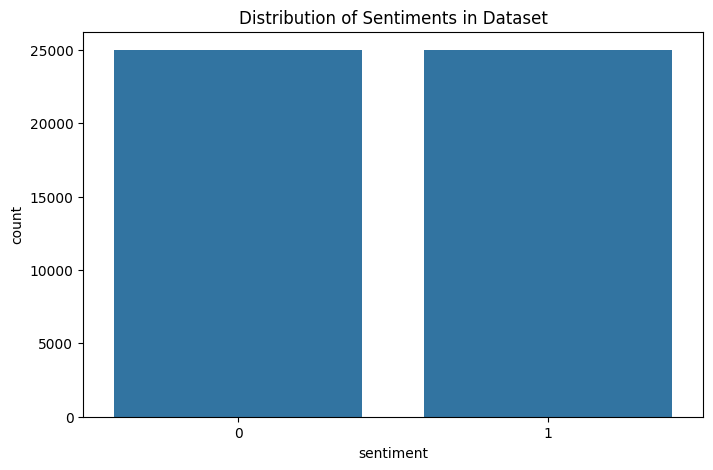

In [9]:
plt.figure(figsize=(8,5))
sns.countplot(x=data['sentiment'])
plt.title("Distribution of Sentiments in Dataset")
plt.show()

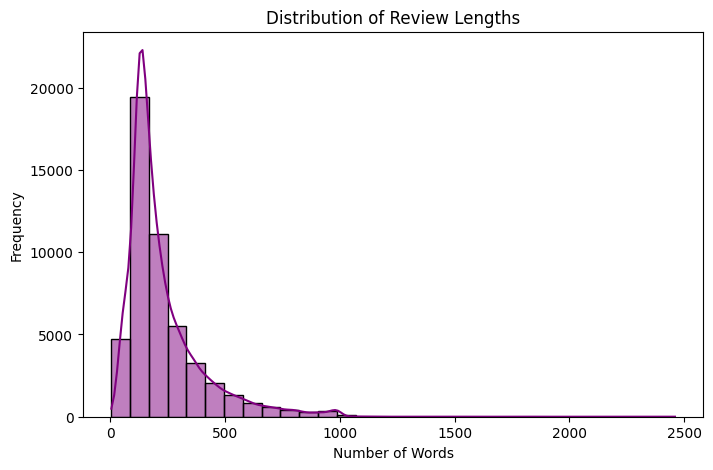

In [10]:
review_lengths = data['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(review_lengths, bins=30, kde=True, color='purple')
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

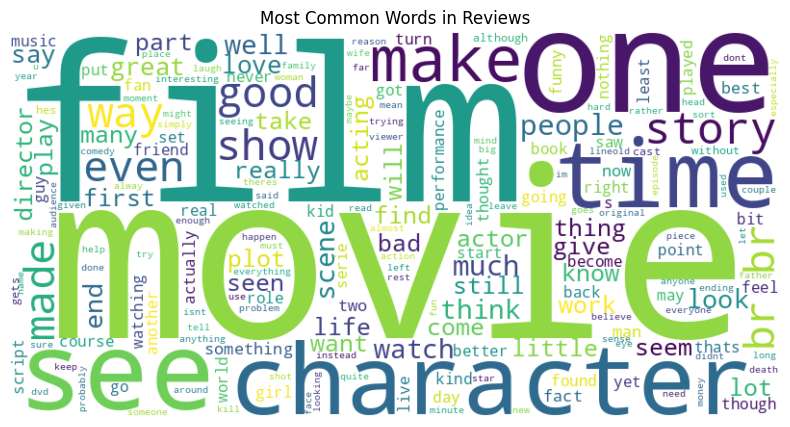

In [11]:
from wordcloud import WordCloud
all_words = ' '.join(data['review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Reviews")
plt.show()